In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"

# Load the dataset
data = pd.read_csv(url)
y = data['medv'].copy()
X = data.drop('medv', axis=1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def soft_thresholding(x, lambda_):
    return np.sign(x) * max(abs(x) - lambda_, 0)

def coordinate_descent_lasso(X, y, lambda_, num_iters=1000, tol=1e-4):
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    for iteration in range(num_iters):
        w_old = w.copy()

        # Update each coordinate
        for j in range(n):
            Xj = X[:, j]
            residual = y - (X @ w + b)
            rho = Xj @ residual + w[j] * (Xj @ Xj)

            # Soft thresholding
            w[j] = soft_thresholding(rho, lambda_) / (Xj @ Xj)

        # Update intercept
        b = np.mean(y - X @ w)

        # Check for convergence
        if np.linalg.norm(w - w_old, ord=1) < tol:
            break

    return w, b

# Set lambda_ (regularization strength)
lambda_ = 0.1
w, b = coordinate_descent_lasso(X_train, y_train, lambda_)

from sklearn.metrics import mean_squared_error

# Prediction on test data
y_pred = X_test @ w + b
mse = mean_squared_error(y_test, y_pred)
print("MSE for lasso regression: ", mse)

MSE for lasso regression:  24.29203247490197


In [ ]:
def coordinate_descent_least_squares_with_bias(X, y, num_iters=1000, tol=1e-4):
    m, n = X.shape
    w = np.zeros(n)
    b = 0  # Initialize the bias term

    for iteration in range(num_iters):
        w_old = w.copy()
        b_old = b

        # Update the bias term
        residual_b = y - (X @ w + b)
        b += np.sum(residual_b) / m

        for j in range(n):
            Xj = X[:, j]
            residual = y - (X @ w + b) + Xj * w[j]
            w[j] = Xj @ residual / (Xj @ Xj)

        # Check for convergence
        if np.linalg.norm(w - w_old) < tol and abs(b - b_old) < tol:
            break

    return w, b

# Example usage with the Boston Housing dataset
w_ls, b_ls = coordinate_descent_least_squares_with_bias(X_train, y_train)
y_pred_ls = X_test @ w_ls + b_ls
mse_ls = mean_squared_error(y_test, y_pred_ls)
print("MSE for Least Squares with Bias: ", mse_ls)

MSE for Least Squares with Bias:  24.29127725144234


In [ ]:
# Convert target to binary
median_val = y.median()
y_binary = (y > median_val).astype(int)

# Split the binary data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_train_bin = X_train_bin.values
y_train_bin = y_train_bin.values
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def coordinate_descent_logistic_with_bias(X, y, num_iters=1000, tol=1e-4, lambda_=0.01):
    m, n = X.shape
    w = np.zeros(n)
    b = 0  # Initialize bias term

    for iteration in range(num_iters):
        w_old = w.copy()
        b_old = b

        # Update bias
        predictions = sigmoid(X @ w + b)
        residual = y - predictions
        b_gradient = -np.sum(residual) / m  # Gradient for bias
        b -= lambda_ * b_gradient

        for j in range(n):
            Xj = X[:, j]
            predictions = sigmoid(X @ w + b)  # Update predictions including bias
            residual = y - predictions
            gradient = -(Xj @ residual) / m
            w[j] -= lambda_ * gradient

        if np.linalg.norm(w - w_old) < tol and abs(b - b_old) < tol:
            break

    return w, b

# X_train_bin = X_train_bin.values
# y_train_bin = y_train_bin.values

w_log = coordinate_descent_logistic(X_train_bin, y_train_bin)
y_pred_prob_log = sigmoid(X_test_bin @ w_log)
accuracy = np.mean(y_pred_log == y_test_bin)
mse_log = mean_squared_error(y_test_bin, y_pred_prob_log)

print("Accuracy for Logistic Regression: ", accuracy)
print("MSE for Logistic Regression: ", mse_log)

<ipython-input-44-53b98b46caad>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy for Logistic Regression:  0.3431372549019608
MSE for Logistic Regression:  0.6568406765925959


In [ ]:
def model_accuracy(y_true, y_pred, task_type='regression', tolerance=0.1):
    """
    Calculates the accuracy for predictions. For regression, predictions are considered
    correct if they are within a specified tolerance percentage of the actual values.
    For classification, it calculates the percentage of exact matches.

    Args:
    y_true (np.array): Actual values.
    y_pred (np.array): Predicted values.
    task_type (str): Type of task 'regression' or 'classification'.
    tolerance (float): The percentage of the actual value that predictions
                       can differ by and still be considered correct (for regression).

    Returns:
    float: The accuracy of the predictions.
    """
    if task_type == 'classification':
        # Assume y_pred for classification is already in the form of 0s and 1s
        return np.mean(y_pred == y_true)
    elif task_type == 'regression':
        return np.mean(np.abs((y_pred - y_true) / y_true) <= tolerance)
    else:
        raise ValueError("Unsupported task type provided. Use 'classification' or 'regression'.")

# Usage for Lasso and Least Squares Regression
tolerance = 0.1  # 10% tolerance
acc_lasso = model_accuracy(y_test, y_pred, task_type='regression', tolerance=tolerance)
acc_least_squares = model_accuracy(y_test, y_pred_ls, task_type='regression', tolerance=tolerance)

# Usage for Logistic Regression (assuming y_pred_prob_log is converted to binary predictions)
y_pred_log = (y_pred_prob_log > 0.5).astype(int)  # Convert probabilities to binary predictions
acc_logistic = model_accuracy(y_test_bin, y_pred_log, task_type='classification')

print("Accuracy for Lasso Regression within 10% tolerance: ", acc_lasso)
print("Accuracy for Least Squares Regression within 10% tolerance: ", acc_least_squares)
print("Accuracy for Logistic Regression: ", acc_logistic)

Accuracy for Lasso Regression within 10% tolerance:  0.46078431372549017
Accuracy for Least Squares Regression within 10% tolerance:  0.46078431372549017
Accuracy for Logistic Regression:  0.3431372549019608


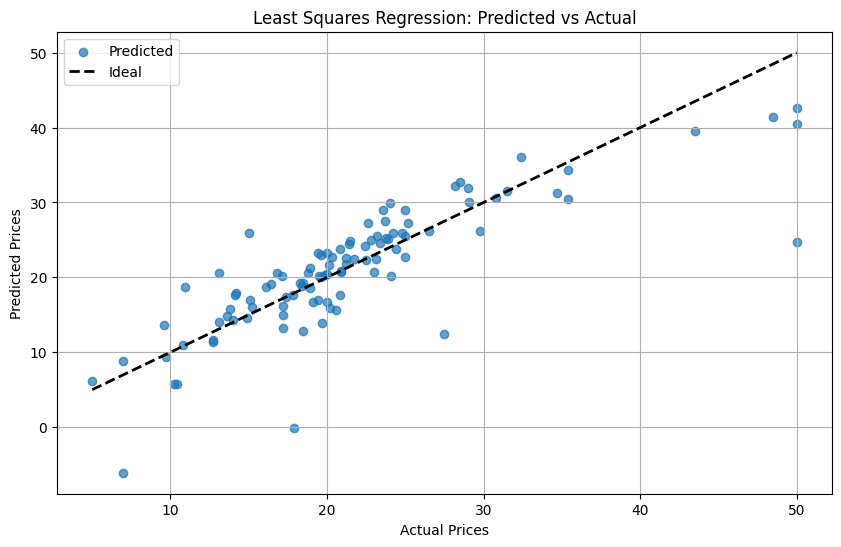

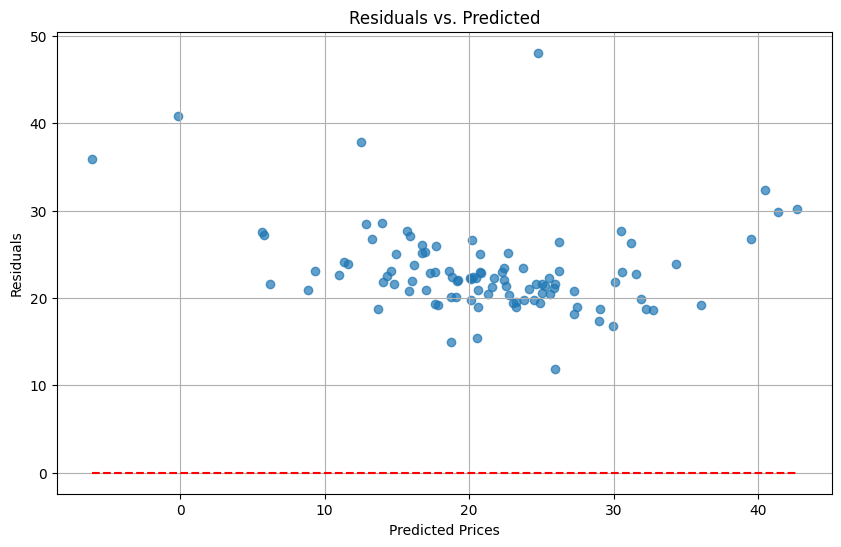

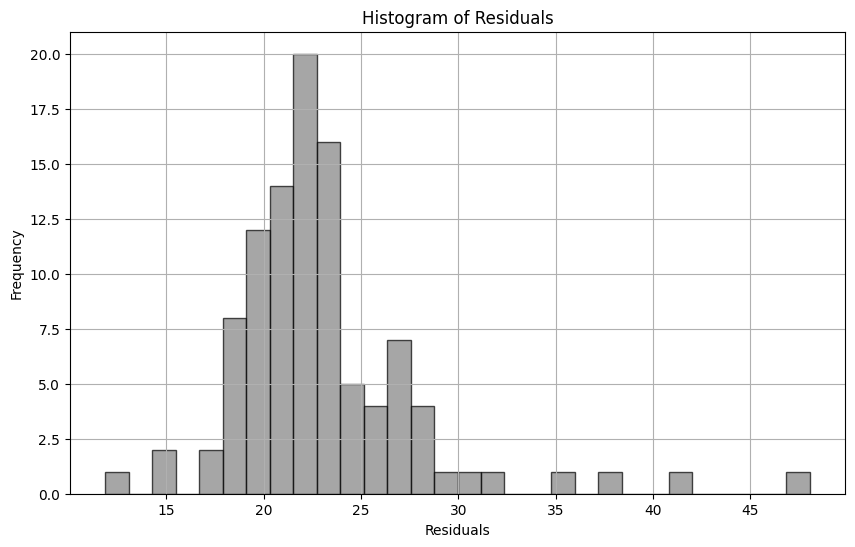

In [ ]:
import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ls, alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Least Squares Regression: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot (residuals vs. predicted)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ls, residuals, alpha=0.7)
plt.hlines(y=0, xmin=y_pred_ls.min(), xmax=y_pred_ls.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.grid(True)
plt.show()

# Residuals histogram to check for normality
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='gray', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()